In [274]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

In [275]:

c2 = 0.2

alpha = 1

def loss_function(a, y):
    return c2*(a-y)**2 -alpha



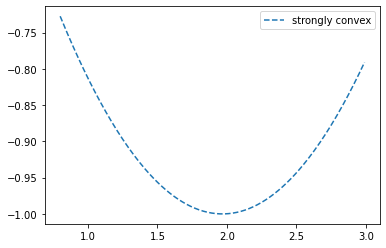

In [276]:
# evenly sampled time at 200ms intervals
thetas = np.arange(0.8, 3., 0.01)
y = np.random.normal(loc=1, scale=1)

# red dashes, blue squares and green triangles
plt.plot(thetas, loss_function(thetas, y), '--', label='strongly convex')
plt.legend()
plt.show()

In [277]:
def evaluate_theta(theta, random_seed):
    rng = np.random.RandomState(random_seed)
    size=10000
    actions = rng.normal(loc=theta, scale=1, size=size)
    y = rng.normal(loc=1, scale=0.3, size=size)
    loss = np.mean(c2*(actions-y)**2 -alpha)
    return loss
    

In [278]:
import jax
import jax.numpy as jnp
import jaxopt

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

def conservative_loss(param, data):
    logging_samples, logging_losses, logging_propensities = data
    n = logging_losses.shape[0]
    lambd = np.sqrt(18*(np.log(n)))
#     lambd = 0.01
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean + lambd / np.sqrt(n) * std 



In [279]:
def optimize(loss_fun, init_parameter, args):
    lower_bounds = -100*jnp.ones_like(init_parameter)
    upper_bounds = 100*jnp.ones_like(init_parameter)
    bounds = (lower_bounds, upper_bounds)

    lbfgsb = jaxopt.ScipyBoundedMinimize(fun=loss_fun, method="l-bfgs-b").run(init_parameter, bounds=bounds, data=args)

    lbfgs_sol = lbfgsb.params
        
    return lbfgs_sol

# Experiment

In [280]:
y_scale = 0.3

def get_logging_data(n_samples, logging_mu, logging_scale, random_seed=123):

    rng = np.random.RandomState(random_seed)
    y_0 = rng.normal(loc=1, scale=y_scale)
    action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
    losses = loss_function(action_samples, y_0)
    logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
    propensities = logging_pdf(action_samples)
    loss = np.mean(losses)

    logging_data = action_samples, losses, propensities

    return logging_data


### Repeated CRM

In [281]:

def repeated_crm_experiment(logging_mu, logging_scale, settings, random_seed=123):

    loss_fun = conservative_loss 
    print('-' * 80)
    print('CRM experiment, \mu_0={}, \sigma={}, seed {}'.format(logging_mu, logging_scale, random_seed))
    
    rng = np.random.RandomState(random_seed)
    repeated_crm_online_losses = []

    M = settings['M']
    n_samples = settings['n_0']
    n_total = n_samples
    mu = logging_mu 
    logging_pdf = norm(loc=logging_mu\
                       , scale=logging_scale).pdf
    optimized_mus = [mu]
    logging_data = get_logging_data(n_samples, logging_mu, logging_scale, random_seed)
    logging_samples, logging_losses, logging_propensities = logging_data

    for m in range(M):
        print('Rollout {}'.format(m))

        init_parameter = jnp.array(logging_mu, dtype='float32')
        args = logging_data

        optimized_mu = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)

            
        mu = optimized_mu._value
    
        n_samples *= 2 
        y_m = rng.normal(loc=1, scale=y_scale)
        action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
        losses = loss_function(action_samples, y_m)
        propensities = logging_pdf(action_samples)
        online_loss = evaluate_theta(mu, random_seed)
        repeated_crm_online_losses.append(online_loss)

        logging_samples = np.hstack([logging_samples, action_samples])
        logging_losses = np.hstack([logging_losses, losses])
        logging_propensities = np.hstack([logging_propensities, propensities])
        logging_data = logging_samples, logging_losses, logging_propensities
        n_total += n_samples
    
    return repeated_crm_online_losses


### Sequential CRM

In [282]:
def sequential_crm_experiment(logging_mu, logging_scale, settings, random_seed=123):

    loss_fun = conservative_loss 
    
    print('-' * 80)
    print('SCRM experiment, \mu_0={}, \sigma={}, seed {}'.format(logging_mu, logging_scale, random_seed))
    
    M = settings['M']
    n_samples = settings['n_0']
    
    
    
    logging_data = get_logging_data(n_samples, logging_mu, logging_scale, random_seed)
    
    rng = np.random.RandomState(random_seed)
    
    mu = logging_mu
    optimized_mus = [mu]
    sequential_crm_online_losses = []

    for m in range(M):
        
        print('Rollout {}'.format(m))
        
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data

        optimized_mu = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)
        


        ### New logging data
        n_samples *= 2
        mu = optimized_mu._value

        logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
        y_m = rng.normal(loc=1, scale=y_scale)
        logging_losses = loss_function(logging_samples, y_m)
        online_loss = evaluate_theta(mu, random_seed)
        sequential_crm_online_losses.append(online_loss)
        logging_pdf = norm(loc=mu, scale=logging_scale).pdf
        logging_propensities = logging_pdf(logging_samples)


        logging_data = logging_samples, logging_losses, logging_propensities

    
    return sequential_crm_online_losses



### Plot results

In [283]:
def do_experiment(logging_mu, logging_scale, settings):
    repeated_crm_losses = []
    sequential_crm_losses = []

    for random_seed in range(5):
        repeated_crm_losses.append(repeated_crm_experiment(logging_mu, logging_scale, settings, random_seed))
        sequential_crm_losses.append(sequential_crm_experiment(logging_mu, logging_scale, settings, random_seed))

    repeated_crm_losses = np.array(repeated_crm_losses)
    crm_losses = np.mean(repeated_crm_losses, axis=0)
    crm_losses_std = np.std(repeated_crm_losses, axis=0)

    sequential_crm_losses = np.array(sequential_crm_losses)
    scrm_losses = np.mean(sequential_crm_losses, axis=0)
    scrm_losses_std = np.std(sequential_crm_losses, axis=0)
    return crm_losses, crm_losses_std, scrm_losses, scrm_losses_std

In [284]:

def do_experiments(delta, settings):

    crm_perfs = []
    crm_perfs_std = []
    scrm_perfs = []
    scrm_perfs_std = []

    optimal_mu = 1
    logging_mu = optimal_mu + delta

    logging_scales = [0.1, 0.3, 1, 3]

    for sigma in logging_scales:
        crm_losses, crm_losses_std, scrm_losses, scrm_losses_std = do_experiment(logging_mu, sigma, settings)
        crm_perfs.append(crm_losses)
        crm_perfs_std.append(crm_losses_std)
        scrm_perfs.append(scrm_losses)
        scrm_perfs_std.append(scrm_losses_std)

    
    return crm_perfs, crm_perfs_std, scrm_perfs, scrm_perfs_std

In [285]:

deltas = [0.1, 0.3, 1, 3, 10, 30, 100]

settings = {
    'M':15,
    'n_0':100
}

crm_perfs_by_delta = []
std_crm_perfs_by_delta = []
scrm_perfs_by_delta = []
std_scrm_perfs_by_delta = []

for delta in deltas:
    crm_perfs, crm_perfs_std, scrm_perfs, scrm_perfs_std = do_experiments(delta, settings)
    crm_perfs_by_delta.append(crm_perfs)
    std_crm_perfs_by_delta.append(crm_perfs_std)
    scrm_perfs_by_delta.append(scrm_perfs)
    std_scrm_perfs_by_delta.append(scrm_perfs_std)

--------------------------------------------------------------------------------
CRM experiment, \mu_0=1.1, \sigma=0.1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4


KeyboardInterrupt: 

In [267]:
crm_sigma_01_final_losses = []
crm_sigma_03_final_losses = []
crm_sigma_1_final_losses = []
crm_sigma_3_final_losses = []
crm_min_final_losses = []

scrm_sigma_01_final_losses = []
scrm_sigma_03_final_losses = []
scrm_sigma_1_final_losses = []
scrm_sigma_3_final_losses = []
scrm_min_final_losses = []

deltas = [0.1, 0.3, 1, 3, 10, 30, 100]


for idx, delta in enumerate(deltas):
    
    # CRM
    loss_s01, loss_s03, loss_s1, loss_s3 = [list_[-1] for list_ in crm_perfs_by_delta[idx]]
    minimal_loss = min([loss_s01, loss_s03, loss_s1, loss_s3])
    
    crm_min_final_losses.append(minimal_loss)

    
    #SCRM
    loss_s01, loss_s03, loss_s1, loss_s3 = [list_[-1] for list_ in scrm_perfs_by_delta[idx]]
    minimal_loss = min([loss_s01, loss_s03, loss_s1, loss_s3])
    
    scrm_min_final_losses.append(minimal_loss)


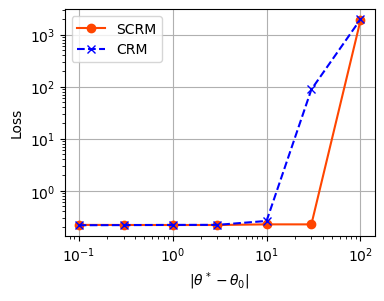

In [273]:
fig=plt.figure(figsize=(4,3), dpi= 100, facecolor='w', edgecolor='k')  # to have big plots
deltas = [0.1, 0.3, 1, 3, 10, 30, 100]

plt.plot(deltas, np.array(scrm_min_final_losses)+1, 'o-', color='orangered', label='SCRM')
plt.plot(deltas, np.array(crm_min_final_losses)+1, 'x--', color='blue', label='CRM')

plt.xscale('log')
#plt.ylim(-0.1, 2*10**3)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel(r'$\vert\theta^* - \theta_0 \vert$')
plt.legend(loc='best')
plt.grid()

plt.savefig('distance_gaussian_example.pdf', bbox_inches = "tight")